# Analysis of minimal pairs and homophones

What we know:

1. The real lexicon is "clumpier" than artificial lexicons. (Dautriche et al, 2016)
2. The real lexicon also has a positive relationship between *number of homophones* and *number of minimal pairs* of a word.
3. The real lexicon actually recycles phonotactically-plausible words *less* than artificial lexicons. 

According to (3), it seems like the real lexicon isn't optimizing purely for phonotactic plausibility. That is, perhaps it optimizes partly for phonotactic plausibility, but also attempts to attenuate ambiguity by "spreading out" phonotactically-friendly wordforms *across* the phonological space, creating larger neighborhoods. Is this true?

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
from tqdm import tqdm

import src.utils as utils

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Pipeline

Here, we define the general pipeline to analyze pre-processed lexicons (real and artificial).

In [181]:
def get_stats_for_lexicon(df_lex):
    """Return basic stats about lexicon. Number of homophones, etc."""
    return {'homophone_percentage': round((len(df_lex[df_lex['num_homophones']>0]) / len(df_lex)), 4),
            'mean_homophones': round(df_lex['num_homophones'].mean(), 4),
            'max_homophones': round(df_lex['num_homophones'].max(), 2),
            'mean_mp': round(df_lex['neighborhood_size'].mean(), 2),
            'max_mp': round(df_lex['neighborhood_size'].max(), 2),
            'total_mp': round(df_lex['neighborhood_size'].sum(), 2)}

In [182]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    mean_mp, max_mp, total_mp = [], [], []
    for i in tqdm(range(NUM_ARTIFICIAL)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                          phon_column="word", word_column="word")
        
        lex_stats = get_stats_for_lexicon(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
        mean_mp.append(lex_stats['mean_mp'])
        max_mp.append(lex_stats['max_mp'])
        total_mp.append(lex_stats['total_mp'])
        
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentages': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones,
            'mean_mp': mean_mp,
            'max_mp': max_mp,
            'total_mp': total_mp
           }
    

In [169]:
def plot_real_vs_art(art_dist, real_value, statistic, language):
    """Compare distribution of test statistics from artificial lexicon to real lexicon."""
    plt.hist(art_dist)
    plt.title("{lan}: {x} in real vs. artificial lexicons".format(lan=language, x=statistic))
    plt.xlabel(statistic)
    plt.ylabel("Count")
    plt.axvline(x=real_value, linestyle="dotted")

In [155]:
def load_lexicons_for_language(language):
    """Loads lexicons for a given language."""
    df_real = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_all_mps.csv".format(lan1=language,
                                                                                         lan2=language))
    df_real_processed = utils.preprocess_for_analysis(df_real, word_column="Word", phon_column="PhonDISC")
    df_artificials = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_artificial_10_matched_on_sylls_mps.csv".format(lan1=language,
                                                                                                                           lan2=language))
    return df_real, df_real_processed, df_artificials
    

## English

In [183]:
df_celex, df_celex_processed, df_english_artificials = load_lexicons_for_language("english")

/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


In [184]:
len(df_celex)

52438

In [185]:
len(df_celex_processed)

35107

In [196]:
df_english_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [187]:
info_for_english = process_and_extract_artificials(df_english_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


In [188]:
processed_artificials = info_for_english['processed_dataframes']

### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), the real lexicon has higher average neighborhood sizes (and larger maximum neighborhoods) than the artificial lexicons.

Comparing the actual distributions, it seems like this is driven by the real lexicon having a longer, larger tail (consistent with the idea that there is a larger **maximum** neighborhood size in the real lexicon). 

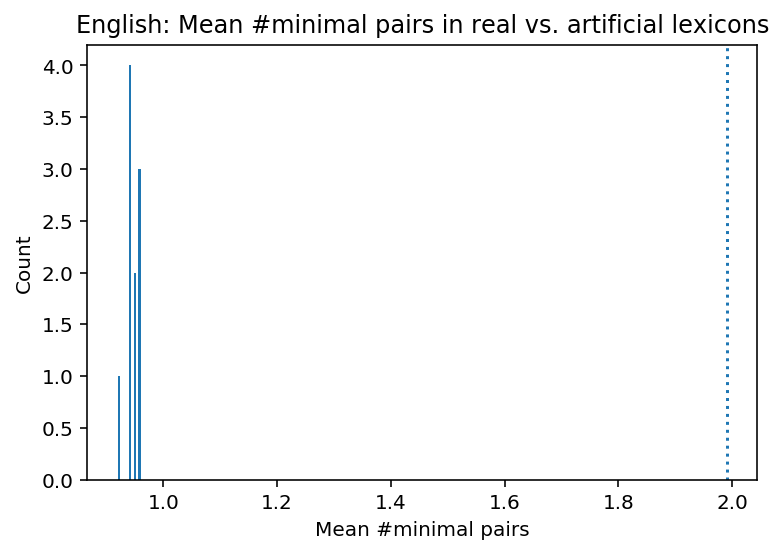

In [189]:
plot_real_vs_art(info_for_english['mean_mp'], df_english_stats['mean_mp'],
                'Mean #minimal pairs', language="English")

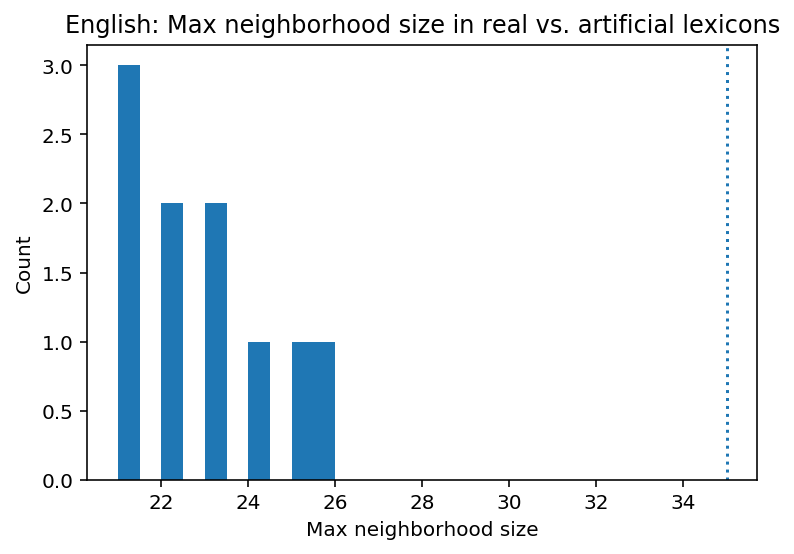

In [190]:
plot_real_vs_art(info_for_english['max_mp'], df_english_stats['max_mp'],
                'Max neighborhood size', language="English")

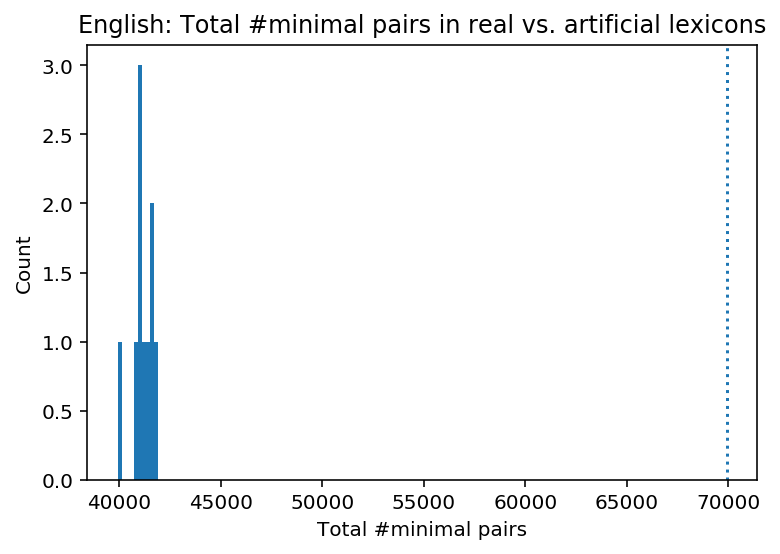

In [191]:
plot_real_vs_art(info_for_english['total_mp'], df_english_stats['total_mp'],
                'Total #minimal pairs', language='English')

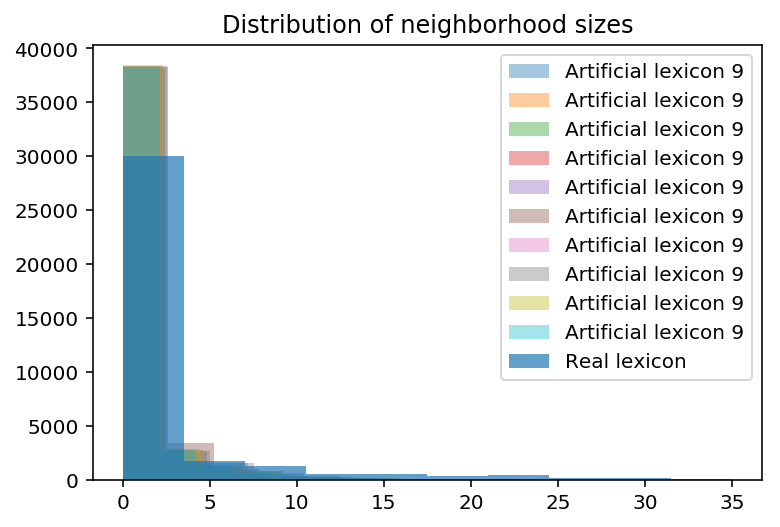

In [192]:
for df_tmp in processed_artificials:
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 80, in some cases) than the real lexicon (below 10). There is also a higher number of *mean* homophones per word.

On the other hand, the real English lexicon has a higher proportion of homophonous wordforms overall.

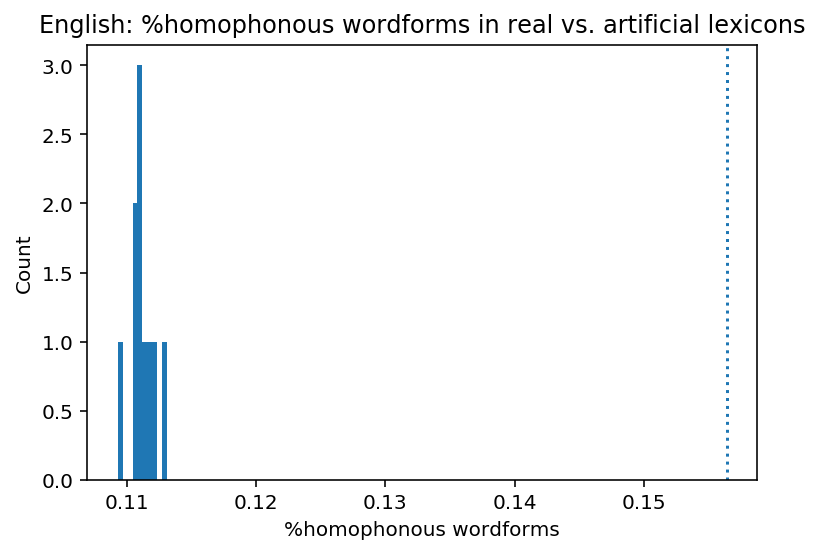

In [193]:
plot_real_vs_art(info_for_english['homophone_percentages'], df_english_stats['homophone_percentage'],
                '%homophonous wordforms', language='English')

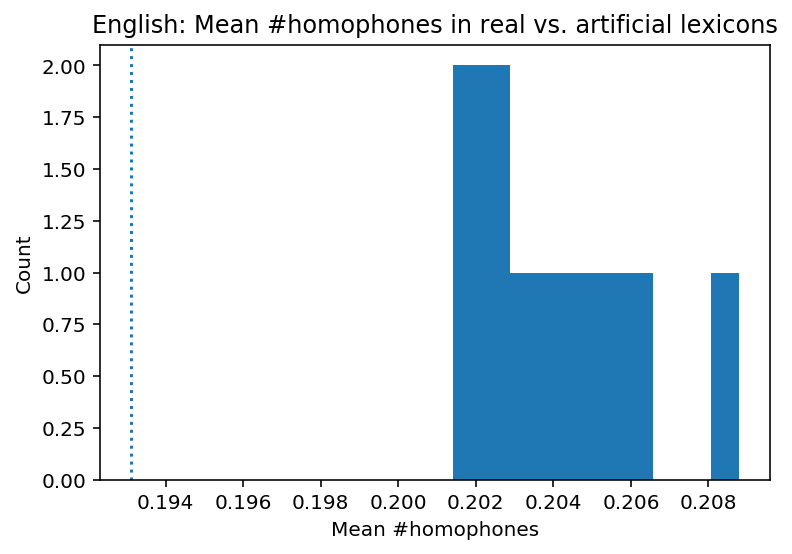

In [194]:
plot_real_vs_art(info_for_english['mean_homophones'], df_english_stats['mean_homophones'],
                'Mean #homophones', language='English')

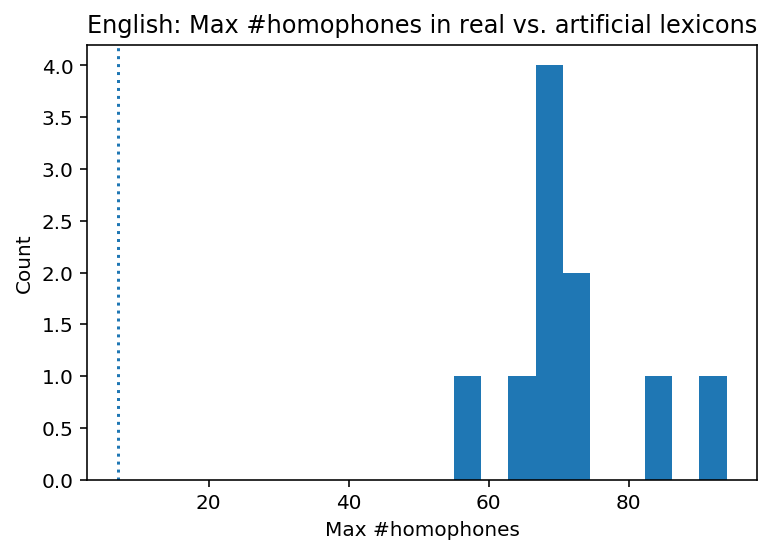

In [195]:
plot_real_vs_art(info_for_english['max_homophones'], df_english_stats['max_homophones'],
                'Max #homophones', language='English')

### Number of homophones and neighborhood size

Do larger neighborhoods have more homophones?

Here, we regress: 
```
#homophones ~ neighborhood size + #syllables + surprisal
```


Interestingly, we find the following effects:

- The effect of **surprisal** is larger in artificial lexicons than the real lexicon (as shown in our other analysis).
- The effect of **#syllables** is larger in artificial lexicons than the real lexicon. This is in contrast to the other analysis. The difference here is that we're also factoring in neighborhood size as a covariate.
- Finally, the effect of **neighborhood size** is larger in the *real* lexicon than artifical lexicons. 

In [61]:
df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                          syl_column='neighborhood_size', 
                                          homophone_column='num_homophones')

/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


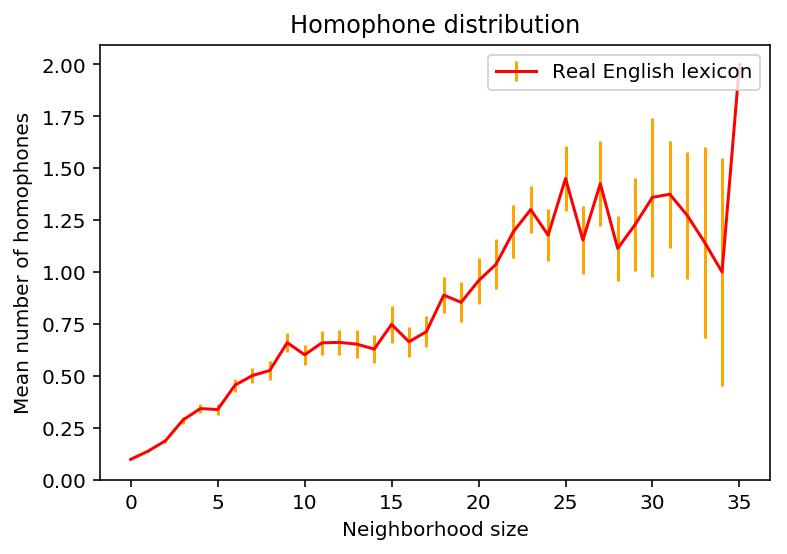

In [62]:
### First plot real
plt.title("Homophone distribution")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean number of homophones")
plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real English lexicon")
# plt.xticks(list(range(1, 10)))
# plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9])
plt.legend(loc='upper right')

In [63]:
artificials = []
for df_tmp_processed in tqdm(processed_artificials):
    
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='neighborhood_size', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


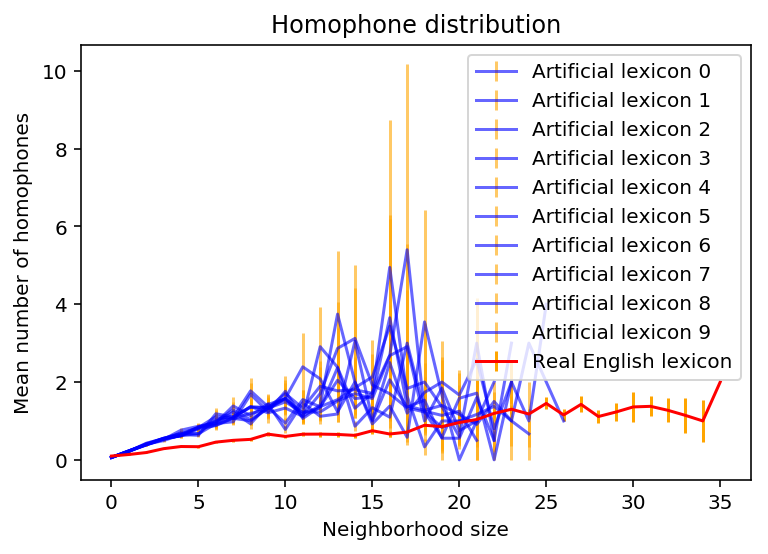

In [64]:
plt.title("Homophone distribution")
plt.xlabel("Neighborhood size")
plt.ylabel("Mean number of homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real English lexicon")
plt.legend(loc='upper right')

In [65]:
result = sm.poisson(formula="num_homophones ~ neighborhood_size + num_sylls_est + surprisal", 
                data=df_celex_processed).fit(disp=0)
real_mp_coef_english = result.params['neighborhood_size']
real_surprisal_coef_english = result.params['surprisal']
real_sylls_coef_english = result.params['num_sylls_est']
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:         num_homophones   No. Observations:                35107
Model:                        Poisson   Df Residuals:                    35103
Method:                           MLE   Df Model:                            3
Date:                Fri, 24 May 2019   Pseudo R-squ.:                  0.1549
Time:                        10:39:12   Log-Likelihood:                -16085.
converged:                       True   LL-Null:                       -19033.
                                        LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0600      0.126     -0.475      0.635      -0.308       0.188
neighborhood_size     0.0535      0.002     31.503      0.000       0.050       0.057
num_sylls_est        -0.6127      0.021    -29.504      0.000      -0.653      -0.572
surprisal            -0.0870      0.027     -3.182      0.001      -0.141      -0.033
=====================================================================================
"""

In [66]:
english_mp_coefs, english_sylls_coefs, english_surprisal_coefs = [], [], []
for df_art in tqdm(processed_artificials):
    result = sm.poisson(formula="num_homophones ~ neighborhood_size + num_sylls_est + surprisal", 
                data=df_art).fit(disp=0)
    english_mp_coefs.append(result.params['neighborhood_size'])
    english_sylls_coefs.append(result.params['num_sylls_est'])
    english_surprisal_coefs.append(result.params['surprisal'])

100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


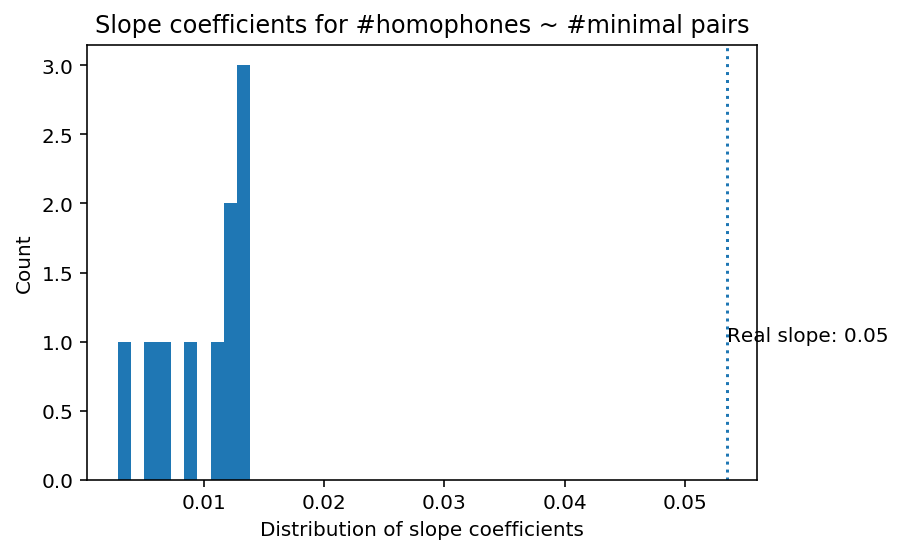

In [67]:
plt.hist(english_mp_coefs)
plt.axvline(x=real_mp_coef_english, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_mp_coef_english, 2)),x=real_mp_coef_english, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #minimal pairs")
# plt.legend(loc='upper right')
plt.show()

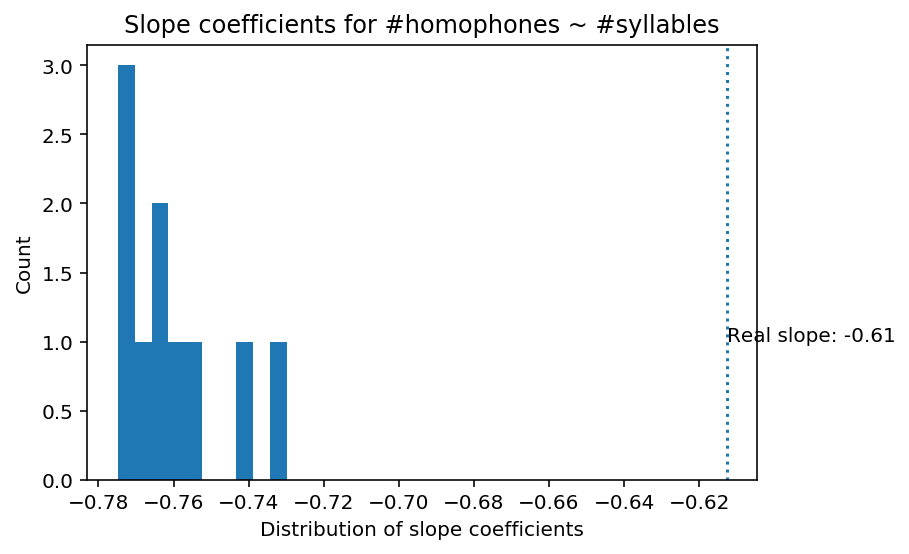

In [68]:
plt.hist(english_sylls_coefs)
plt.axvline(x=real_sylls_coef_english, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_sylls_coef_english, 2)),x=real_sylls_coef_english, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
# plt.legend(loc='upper right')
plt.show()

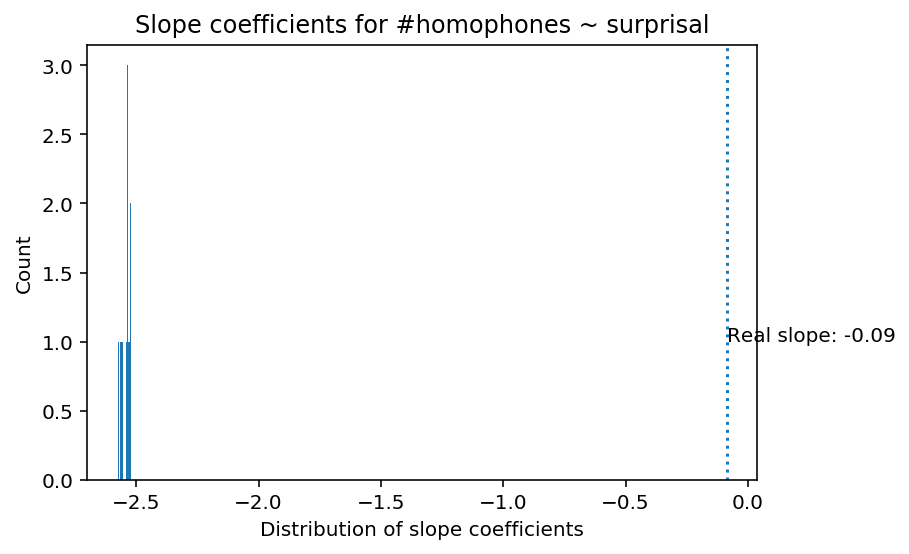

In [69]:
plt.hist(english_surprisal_coefs)
plt.axvline(x=real_surprisal_coef_english, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_surprisal_coef_english, 2)),x=real_surprisal_coef_english, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ surprisal")
# plt.legend(loc='upper right')
plt.show()

### Predicting neighborhood size from number of homophones

Do words with more homophones have larger neighborhoods?

This just takes the analysis above and inverts it.

In [70]:
result = sm.poisson(formula="neighborhood_size ~ num_homophones + num_sylls_est + surprisal", 
                data=df_celex_processed).fit(disp=0)
real_homophone_coef_english = result.params['num_homophones']
real_surprisal_coef_english = result.params['surprisal']
real_sylls_coef_english = result.params['num_sylls_est']
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:      neighborhood_size   No. Observations:                35107
Model:                        Poisson   Df Residuals:                    35103
Method:                           MLE   Df Model:                            3
Date:                Fri, 24 May 2019   Pseudo R-squ.:                  0.5528
Time:                        10:41:18   Log-Likelihood:                -56792.
converged:                       True   LL-Null:                   -1.2699e+05
                                        LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.9178      0.059    149.913      0.000       8.801       9.034
num_homophones     0.1672      0.004     42.106      0.000       0.159       0.175
num_sylls_est     -1.3256      0.008   -170.091      0.000      -1.341      -1.310
surprisal         -1.1642      0.013    -87.231      0.000      -1.190      -1.138
==================================================================================
"""

In [71]:
english_homophones_coefs, english_sylls_coefs, english_surprisal_coefs = [], [], []
for df_art in tqdm(processed_artificials):
    result = sm.poisson(formula="neighborhood_size ~ num_homophones + num_sylls_est + surprisal", 
                data=df_art).fit(disp=0)
    english_homophones_coefs.append(result.params['num_homophones'])
    english_sylls_coefs.append(result.params['num_sylls_est'])
    english_surprisal_coefs.append(result.params['surprisal'])

  0%|          | 0/10 [00:00<?, ?it/s]/Users/seantrott/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 70%|███████   | 7/10 [00:03<00:01,  1.88it/s]/Users/seantrott/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


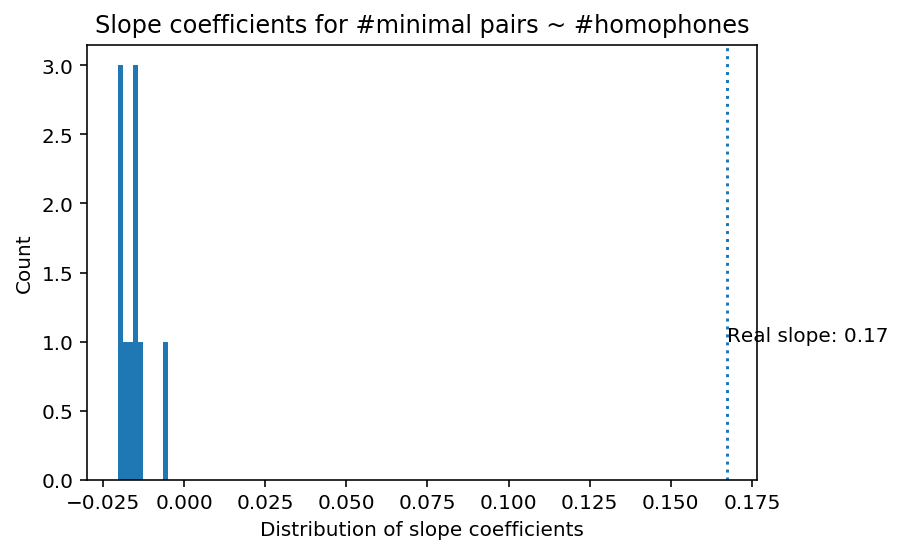

In [74]:
plt.hist(english_homophones_coefs)
plt.axvline(x=real_homophone_coef_english, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_homophone_coef_english, 2)),x=real_homophone_coef_english, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #minimal pairs ~ #homophones")
# plt.legend(loc='upper right')
plt.show()

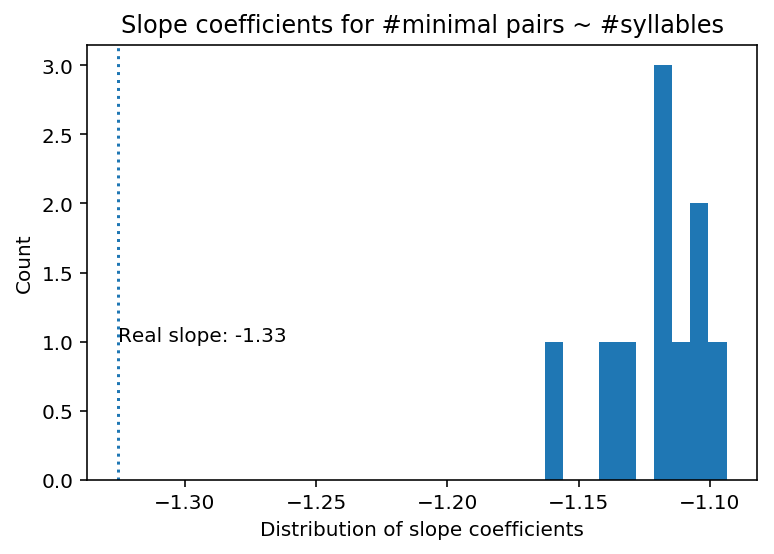

In [76]:
plt.hist(english_sylls_coefs)
plt.axvline(x=real_sylls_coef_english, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_sylls_coef_english, 2)),x=real_sylls_coef_english, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #minimal pairs ~ #syllables")
# plt.legend(loc='upper right')
plt.show()

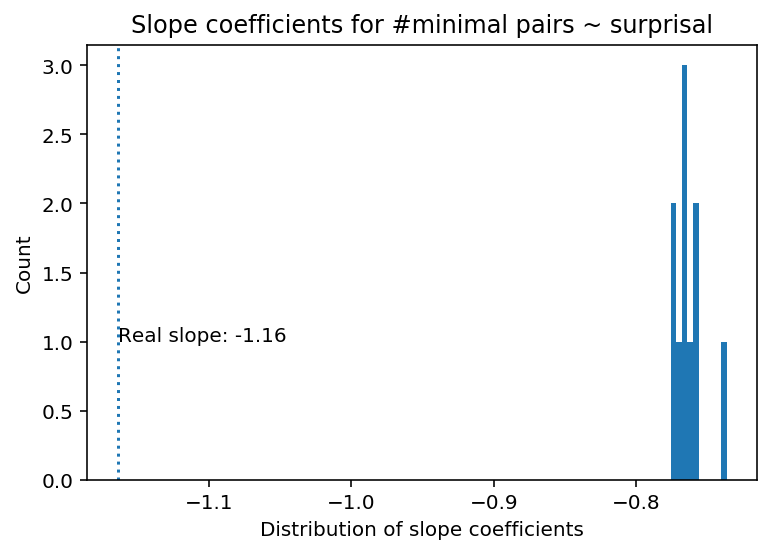

In [77]:
plt.hist(english_surprisal_coefs)
plt.axvline(x=real_surprisal_coef_english, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_surprisal_coef_english, 2)),x=real_surprisal_coef_english, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #minimal pairs ~ surprisal")
# plt.legend(loc='upper right')
plt.show()

# German

In [226]:
df_celex, df_celex_processed, df_german_artificials = load_lexicons_for_language("german")

In [227]:
len(df_celex)

51719

In [228]:
len(df_celex_processed)

50474

In [229]:
df_german_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [230]:
info_for_german = process_and_extract_artificials(df_german_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


In [236]:
processed_artificials = info_for_german['processed_dataframes']

### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), the real lexicon has higher average neighborhood sizes (and larger maximum neighborhoods) than the artificial lexicons.

Comparing the actual distributions, it seems like this is driven by the real lexicon having a longer, larger tail (consistent with the idea that there is a larger **maximum** neighborhood size in the real lexicon). 

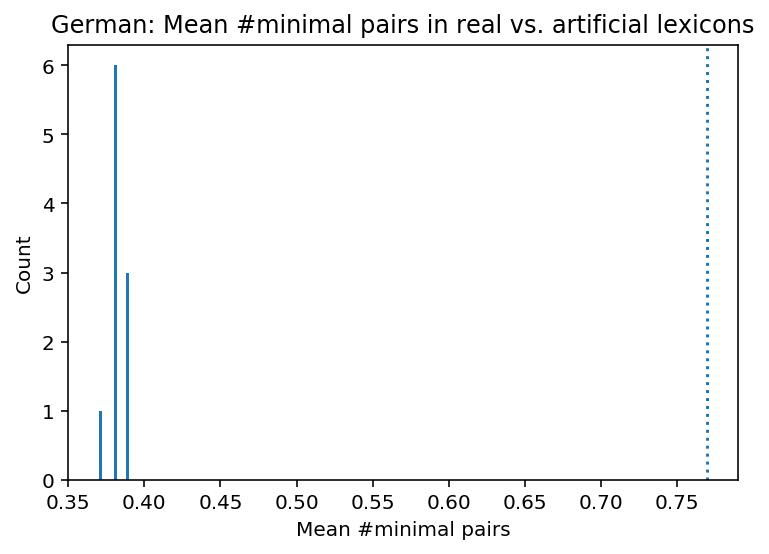

In [232]:
plot_real_vs_art(info_for_german['mean_mp'], df_german_stats['mean_mp'],
                'Mean #minimal pairs', language="German")

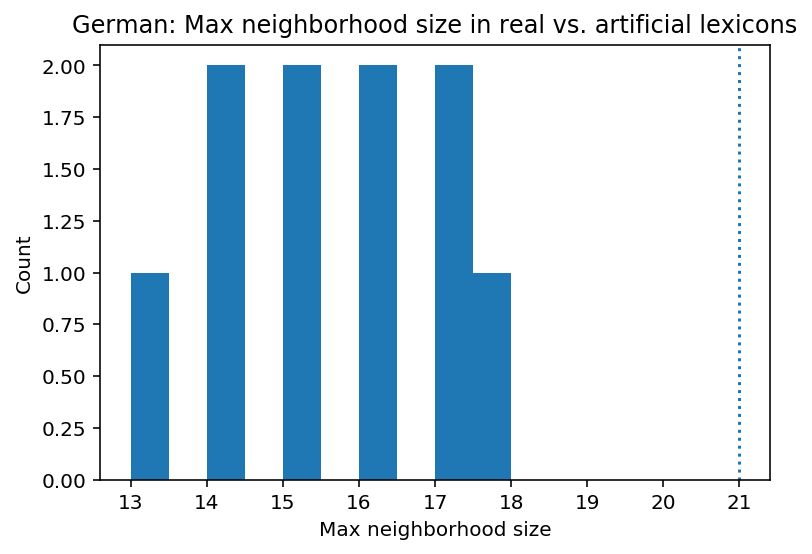

In [233]:
plot_real_vs_art(info_for_german['max_mp'], df_german_stats['max_mp'],
                'Max neighborhood size', language="German")

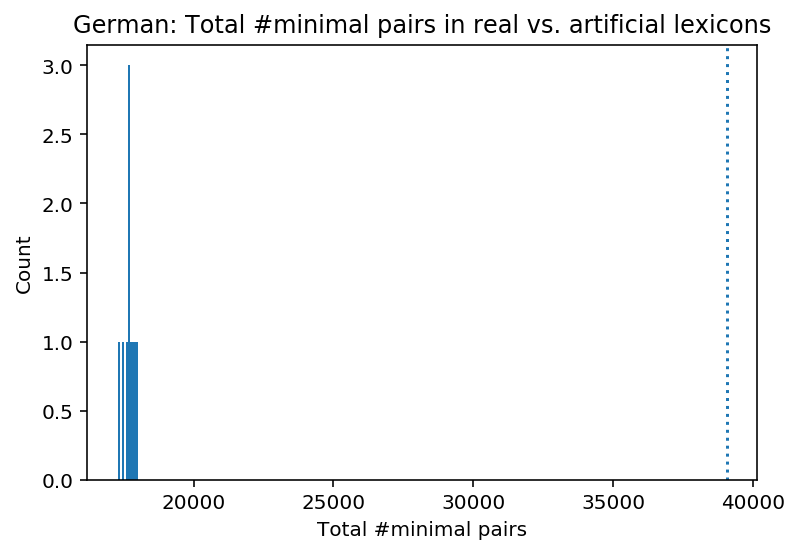

In [234]:
plot_real_vs_art(info_for_german['total_mp'], df_german_stats['total_mp'],
                'Total #minimal pairs', language='German')

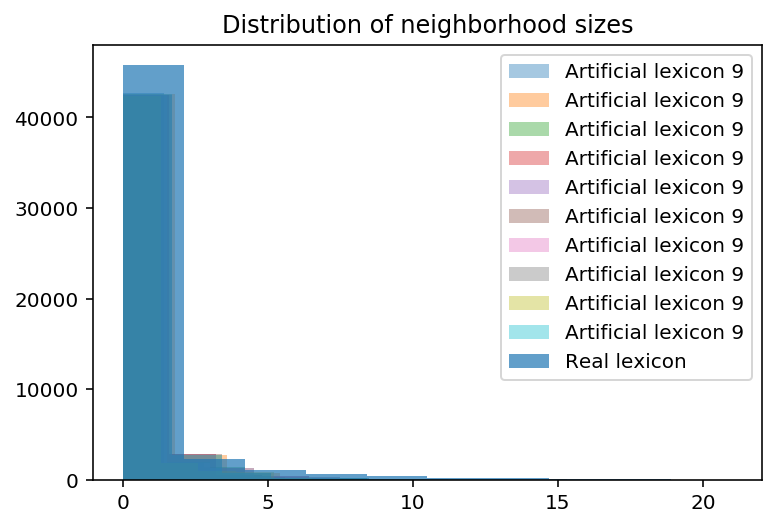

In [237]:
for df_tmp in processed_artificials:
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

### Number of homophones and neighborhood size (German)

Do larger neighborhoods have more homophones?

Here, we regress: 
```
#homophones ~ neighborhood size + #syllables + surprisal
```


Interestingly, we find the following effects:

- The effect of **surprisal** is larger in artificial lexicons than the real lexicon (as shown in our other analysis).
- The effect of **#syllables** is smaller in the artificial lexicons than real lexicon (as shown in the other analysis).
- Finally, the effect of **neighborhood size** is larger in the *real* lexicon than artifical lexicons. 

In [249]:
result = sm.poisson(formula="num_homophones ~ neighborhood_size + num_sylls_est + surprisal", 
                data=df_celex_processed).fit(disp=0)
real_mp_coef_german = result.params['neighborhood_size']
real_surprisal_coef_german = result.params['surprisal']
real_sylls_coef_german = result.params['num_sylls_est']
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:         num_homophones   No. Observations:                50474
Model:                        Poisson   Df Residuals:                    50470
Method:                           MLE   Df Model:                            3
Date:                Fri, 24 May 2019   Pseudo R-squ.:                  0.1334
Time:                        13:19:16   Log-Likelihood:                -5127.6
converged:                       True   LL-Null:                       -5917.0
                                        LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.2547      0.242      5.192      0.000       0.781       1.728
neighborhood_size     0.1169      0.008     14.543      0.000       0.101       0.133
num_sylls_est        -0.2786      0.041     -6.837      0.000      -0.358      -0.199
surprisal            -0.7940      0.050    -16.038      0.000      -0.891      -0.697
=====================================================================================
"""

In [239]:
german_mp_coefs, german_sylls_coefs, german_surprisal_coefs = [], [], []
for df_art in tqdm(processed_artificials):
    result = sm.poisson(formula="num_homophones ~ neighborhood_size + num_sylls_est + surprisal", 
                data=df_art).fit(disp=0)
    german_mp_coefs.append(result.params['neighborhood_size'])
    german_sylls_coefs.append(result.params['num_sylls_est'])
    german_surprisal_coefs.append(result.params['surprisal'])

100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


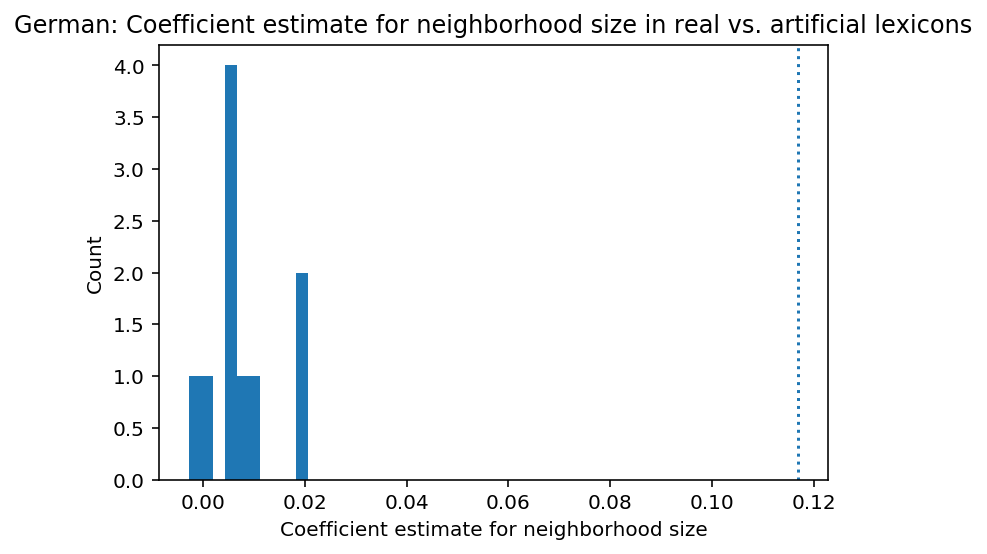

In [240]:
plot_real_vs_art(german_mp_coefs, real_mp_coef_german,
                'Coefficient estimate for neighborhood size', language='German')

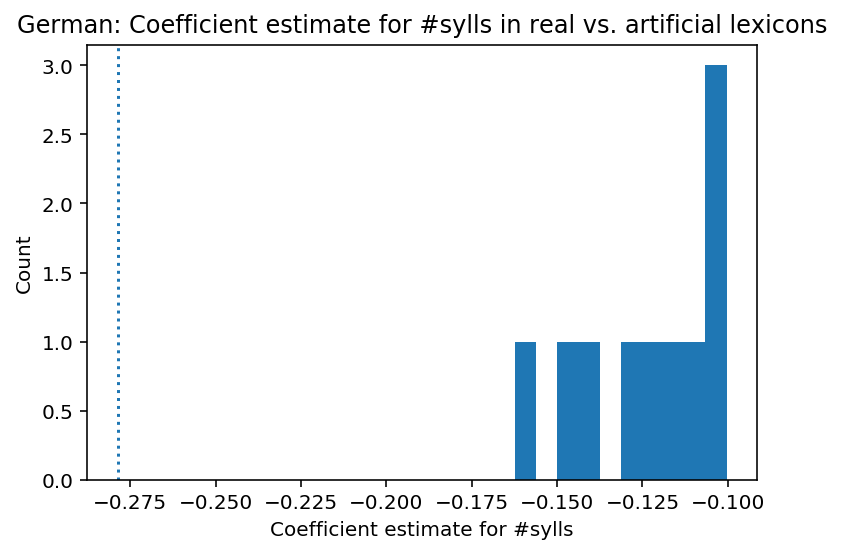

In [241]:
plot_real_vs_art(german_sylls_coefs, real_sylls_coef_german,
                'Coefficient estimate for #sylls', language='German')

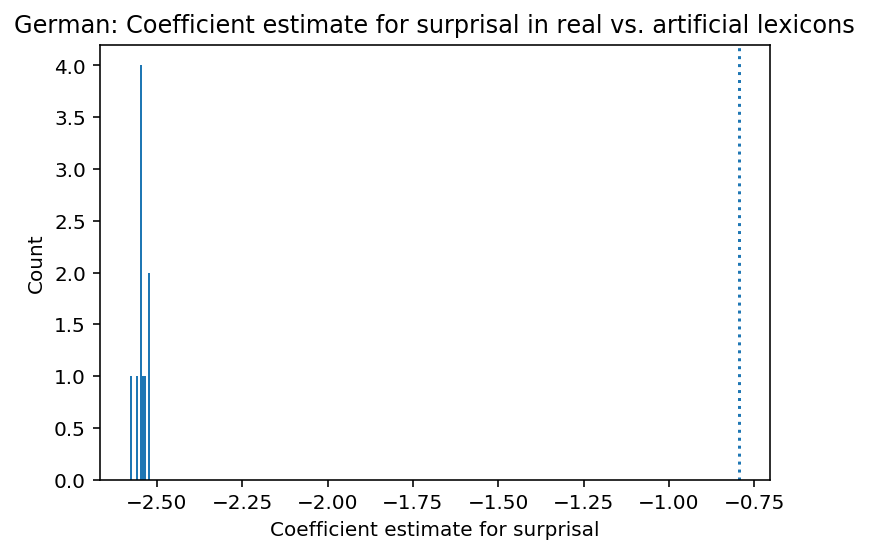

In [242]:
plot_real_vs_art(german_surprisal_coefs, real_surprisal_coef_german,
                'Coefficient estimate for surprisal', language='German')

In [247]:
result = sm.poisson(formula="neighborhood_size ~ num_homophones + num_sylls_est + surprisal", 
                data=df_celex_processed).fit(disp=0)
real_homophone_coef_german = result.params['num_homophones']
real_surprisal_coef_german = result.params['surprisal']
real_sylls_coef_german = result.params['num_sylls_est']
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:      neighborhood_size   No. Observations:                50474
Model:                        Poisson   Df Residuals:                    50470
Method:                           MLE   Df Model:                            3
Date:                Fri, 24 May 2019   Pseudo R-squ.:                  0.3699
Time:                        13:18:52   Log-Likelihood:                -51796.
converged:                       True   LL-Null:                       -82199.
                                        LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.7714      0.041    165.091      0.000       6.691       6.852
num_homophones     0.2306      0.014     16.323      0.000       0.203       0.258
num_sylls_est     -0.7363      0.008    -98.105      0.000      -0.751      -0.722
surprisal         -0.9425      0.009   -102.436      0.000      -0.961      -0.924
==================================================================================
"""